# Random Forest Forecast

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas import DataFrame
import pickle
import seaborn as sns

# Load and preprocess the data
df = pd.read_csv('lawas-rainfall-valid-daily.csv', encoding='latin')
df["DateTime"] = pd.to_datetime(df["DateTime"],format="%Y-%m-%d")
df.set_index("DateTime",inplace=True)
# df['Wind Speed'] = df['Wind Speed'].replace(np.nan, 0)
# df = df.fillna(method='ffill')

Feature Engineering

In [12]:
# Define the sets of features for interaction
source1 = ['Rainfall']
source2 = ['TOTAL', 'ClimAdjust', 'ANOM']
source3 = ['Temperature', 'DewPoint', 'Humidity', 'WindSpeed', 'Pressure']

# Create interaction features
for s1 in source1:
    for s2 in source2:
        # Interaction between source1 and source2
        interaction_term = f'{s1}_{s2}'
        df[interaction_term] = df[s1] * df[s2]
        
    for s3 in source3:
        # Interaction between source1 and source3
        interaction_term = f'{s1}_{s3}'
        df[interaction_term] = df[s1] * df[s3]
        
for s2 in source2:
    for s3 in source3:
        # Interaction between source2 and source3
        interaction_term = f'{s2}_{s3}'
        df[interaction_term] = df[s2] * df[s3]
        
print(df.columns.to_list())

['Rainfall', 'TOTAL', 'ClimAdjust', 'ANOM', 'Temperature', 'DewPoint', 'Humidity', 'WindSpeed', 'Pressure', 'Wind', 'Condition', 'Rainfall_TOTAL', 'Rainfall_ClimAdjust', 'Rainfall_ANOM', 'Rainfall_Temperature', 'Rainfall_DewPoint', 'Rainfall_Humidity', 'Rainfall_WindSpeed', 'Rainfall_Pressure', 'TOTAL_Temperature', 'TOTAL_DewPoint', 'TOTAL_Humidity', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_Temperature', 'ClimAdjust_DewPoint', 'ClimAdjust_Humidity', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_WindSpeed', 'ANOM_Pressure']


In [13]:
# Create rolling statistics for 24, 48, 72 hours (1, 2, 3 days)
for window in [7,14,30]:
    df[f"Rainfall_{window}d_mean"] = df["Rainfall"].rolling(window).mean()
    df[f"Rainfall_{window}d_std"] = df["Rainfall"].rolling(window).std()
    df[f"Rainfall_{window}d_sum"] = df["Rainfall"].rolling(window).sum()

In [14]:
for lag in range(1, 31):
    df[f'Rainfall_lag_{lag}'] = df['Rainfall'].shift(lag)

In [15]:
df.dropna(inplace=True)

                        Rainfall     TOTAL  ClimAdjust      ANOM  Temperature  \
Rainfall                1.000000  0.160214    0.155529 -0.130019    -0.294062   
TOTAL                   0.160214  1.000000    0.997647 -0.941392    -0.252199   
ClimAdjust              0.155529  0.997647    1.000000 -0.962268    -0.253461   
ANOM                   -0.130019 -0.941392   -0.962268  1.000000     0.248126   
Temperature            -0.294062 -0.252199   -0.253461  0.248126     1.000000   
DewPoint                0.129871  0.162045    0.155885 -0.127549     0.355051   
Humidity                0.390410  0.380559    0.376770 -0.348193    -0.692692   
WindSpeed              -0.138659 -0.609965   -0.596386  0.519491     0.380285   
Pressure               -0.022412  0.078790    0.098239 -0.168353    -0.013694   
Rainfall_TOTAL          0.999957  0.164969    0.160386 -0.135050    -0.294361   
Rainfall_ClimAdjust     0.999937  0.165980    0.161439 -0.136218    -0.294468   
Rainfall_ANOM          -0.99

<Axes: >

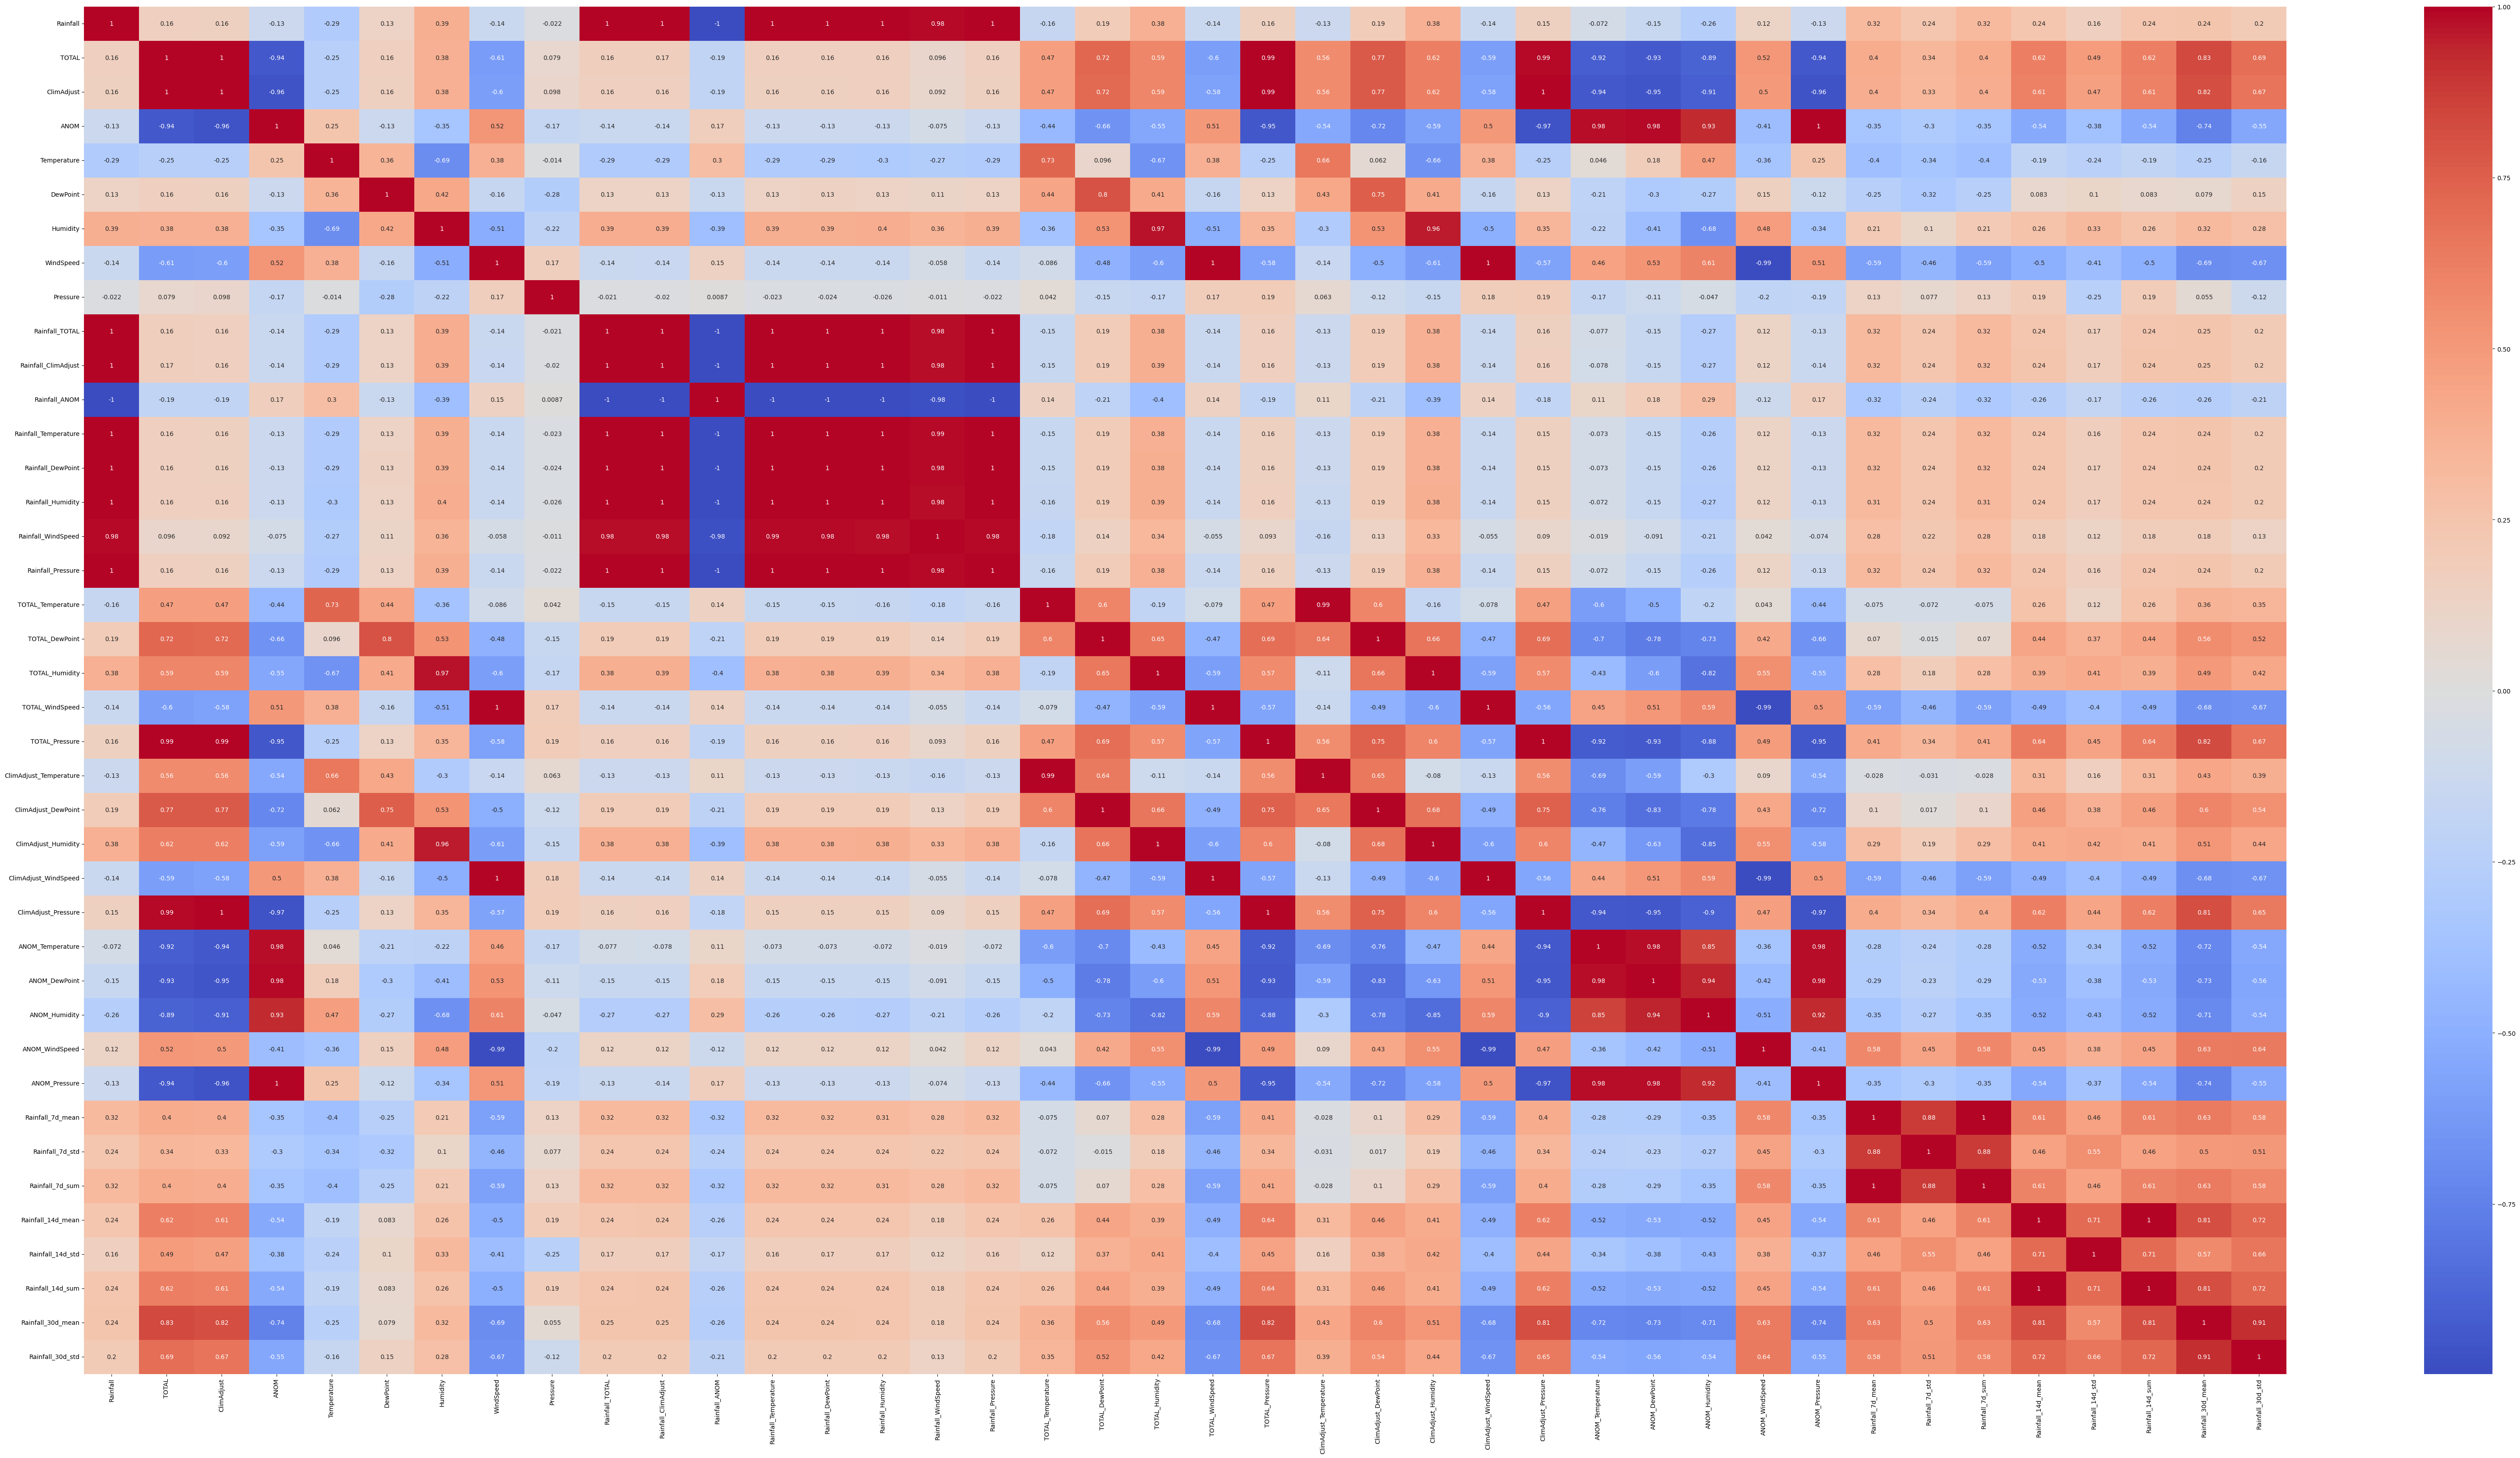

In [16]:
corr_matrix = df.iloc[:, :42].corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(80,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

Dimensionality Reduction

In [17]:
df_dim_red = df.drop(columns=['TOTAL', 'ClimAdjust', 'ANOM', 'DewPoint', 'WindSpeed', 'Pressure', 'TOTAL_DewPoint', 'TOTAL_WindSpeed', 'TOTAL_Pressure', 'ClimAdjust_DewPoint', 'ClimAdjust_WindSpeed', 'ClimAdjust_Pressure', 'ANOM_Temperature', 'ANOM_DewPoint', 'ANOM_Humidity', 'ANOM_WindSpeed', 'ANOM_Pressure'])
df_dim_red = df_dim_red.select_dtypes(include=['number'])

                        Rainfall  Temperature  Humidity  Rainfall_TOTAL  \
Rainfall                1.000000    -0.294062  0.390410        0.999957   
Temperature            -0.294062     1.000000 -0.692692       -0.294361   
Humidity                0.390410    -0.692692  1.000000        0.391173   
Rainfall_TOTAL          0.999957    -0.294361  0.391173        1.000000   
Rainfall_ClimAdjust     0.999937    -0.294468  0.391323        0.999998   
Rainfall_ANOM          -0.997998     0.296711 -0.394645       -0.998518   
Rainfall_Temperature    0.999948    -0.289875  0.388792        0.999875   
Rainfall_DewPoint       0.999959    -0.291362  0.390831        0.999929   
Rainfall_Humidity       0.999692    -0.298156  0.395090        0.999747   
Rainfall_WindSpeed      0.984840    -0.273459  0.355286        0.983992   
Rainfall_Pressure       0.999999    -0.294105  0.390290        0.999960   
TOTAL_Temperature      -0.155506     0.732712 -0.361435       -0.152455   
TOTAL_Humidity          0

<Axes: >

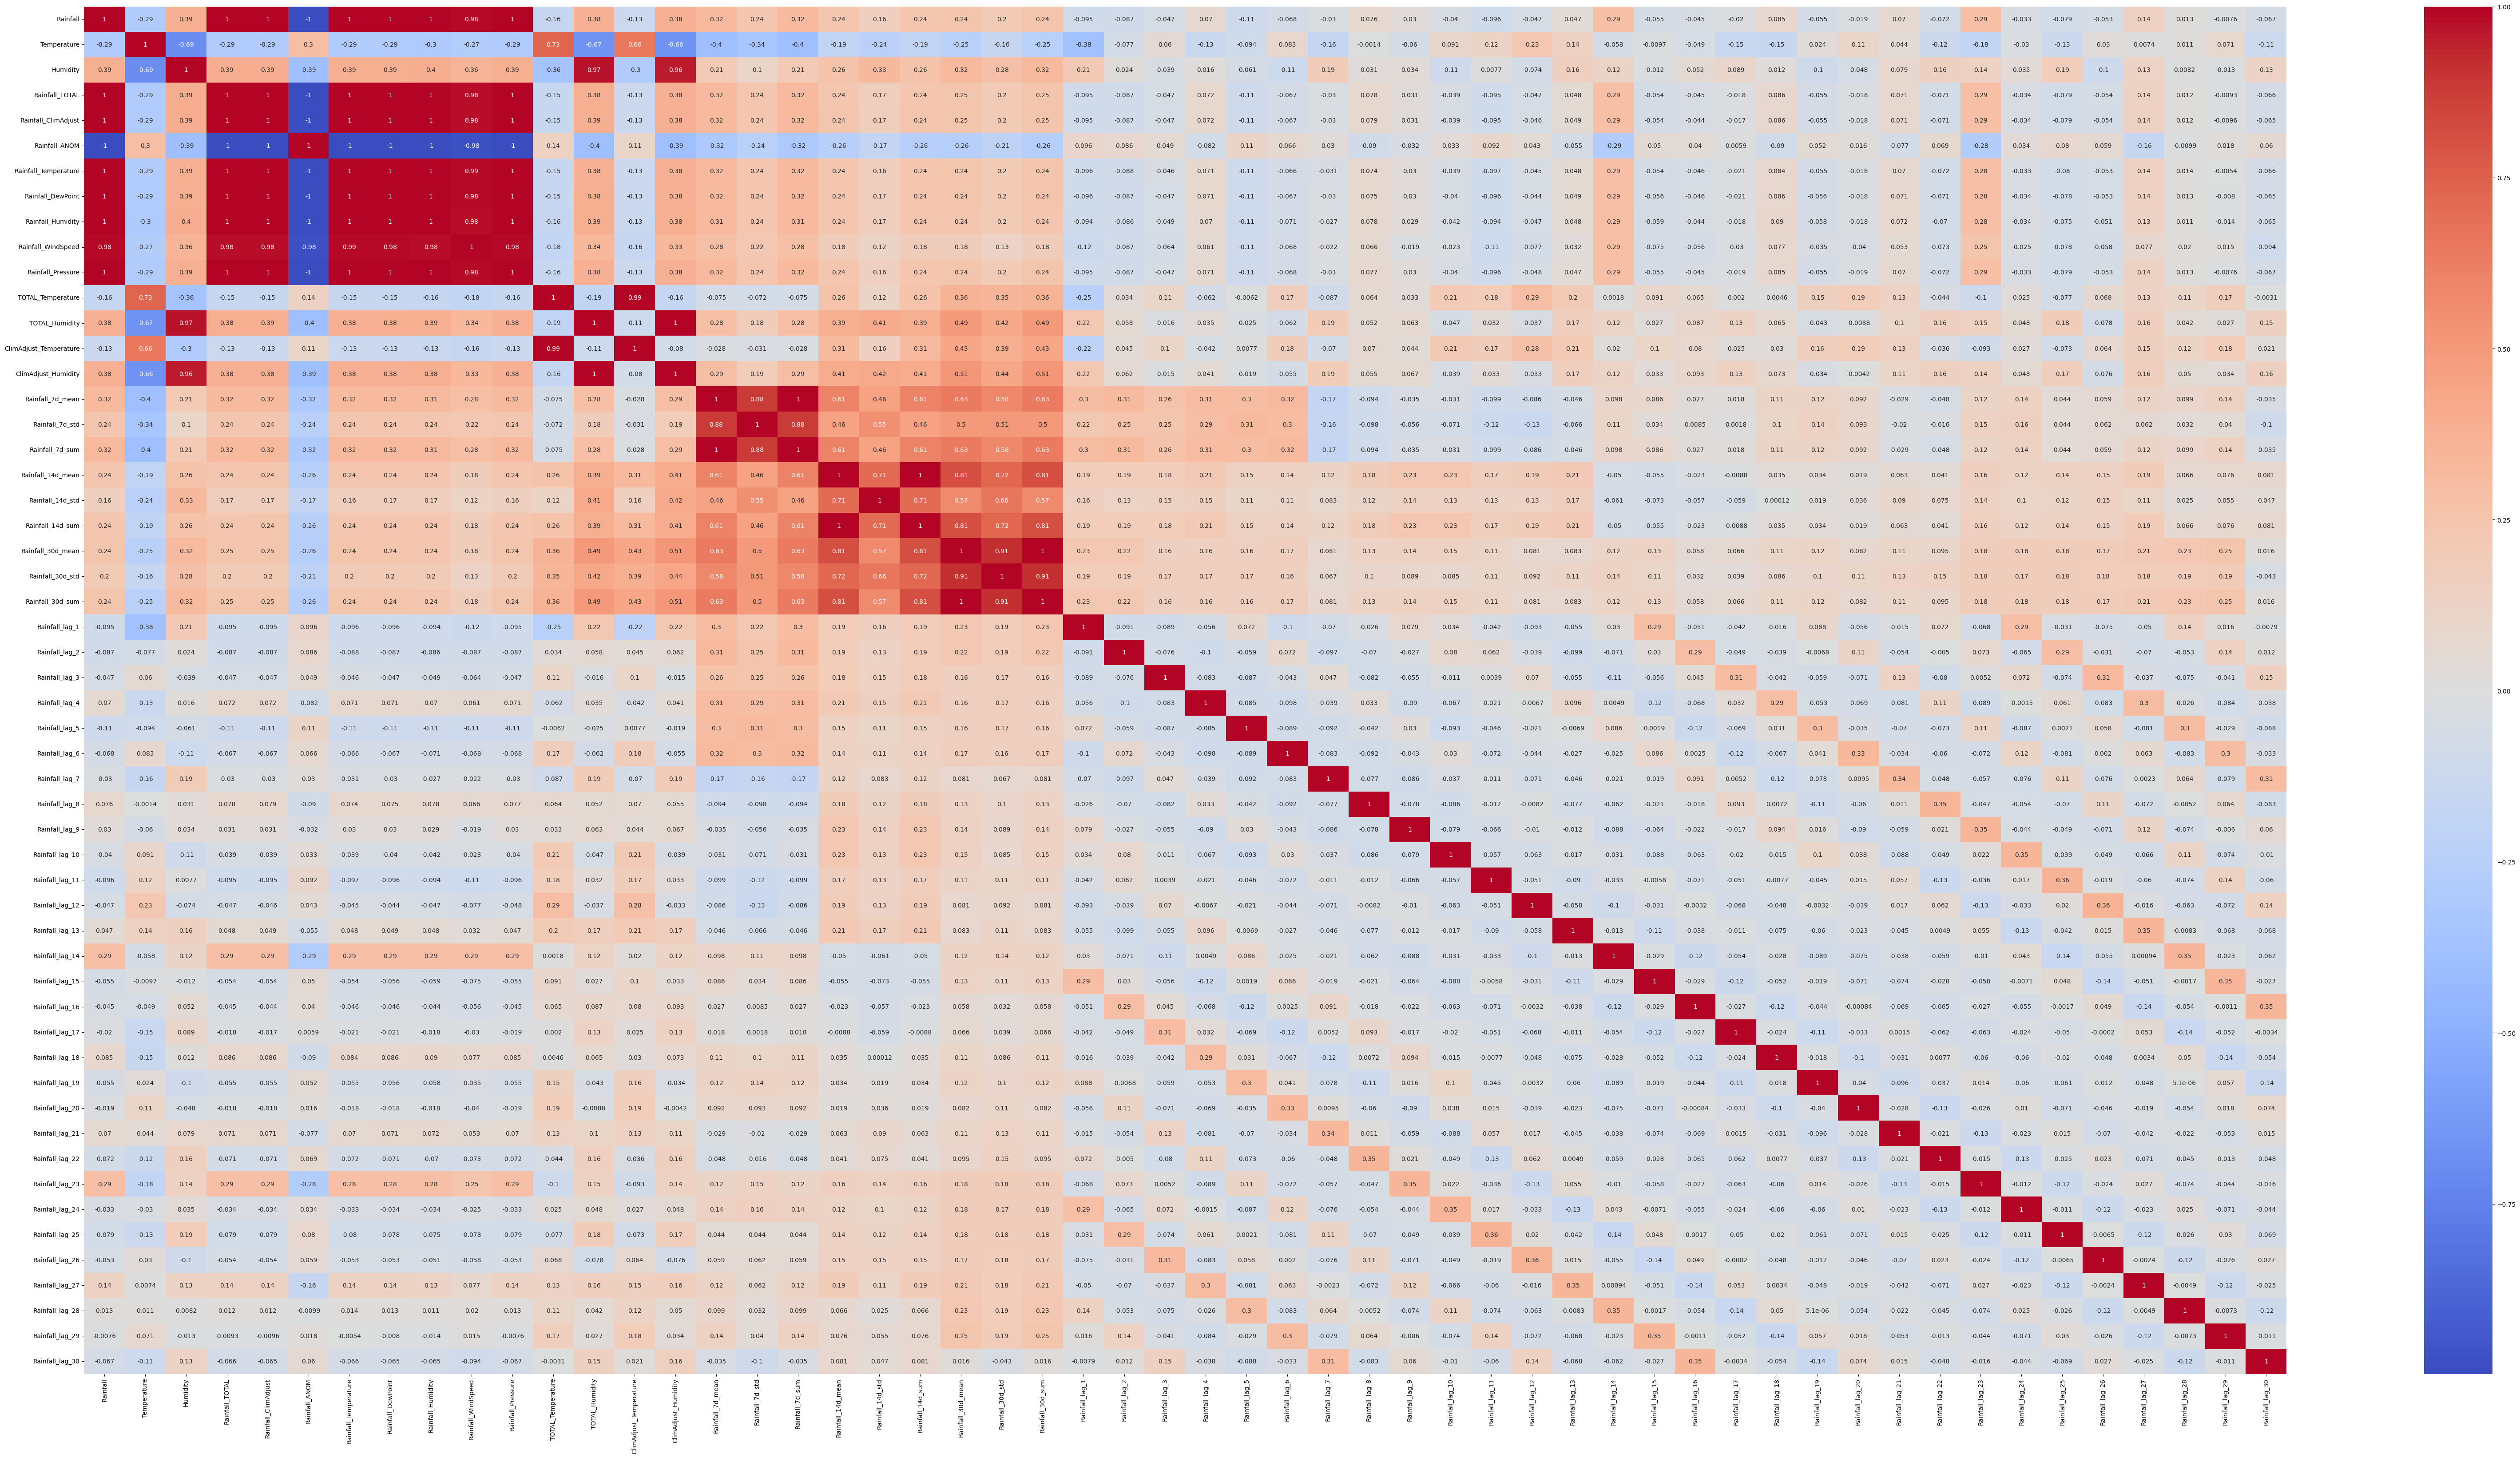

In [18]:
corr_matrix = df_dim_red.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(80,40))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

In [19]:
# Scaling the features and target separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Separate features (lags of all columns) and target (Current_Rainfall)
features = df_dim_red.drop(columns=['Rainfall']).reset_index(drop=True)
target = df_dim_red['Rainfall']

# Scale features and target
features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Forecasting function
def forecast(model, initial_input, num_steps, feature_scaler, target_scaler):
    predictions = []
    current_input = initial_input

    for i in range(num_steps):
        current_input_scaled = feature_scaler.transform(current_input.reshape(1, -1))
        pred_scaled = model.predict(current_input_scaled)
        pred = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
        predictions.append(pred[0][0])

        # Shift the input to include the new prediction as the latest 'lag'
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred[0][0]

    return np.array(predictions)

# RF_model.pkl - Rainfall lagged for 90 days
# RF_model1.pkl - Rainfall lagged for 30 days
with open('RF_model1.pkl', 'rb') as f:
    rf = pickle.load(f)

Evaluation Metrics:
Mean Absolute Error (MAE): 1.73
Mean Squared Error (MSE): 123.88
Root Mean Squared Error (RMSE): 11.13
R² Score: 0.83


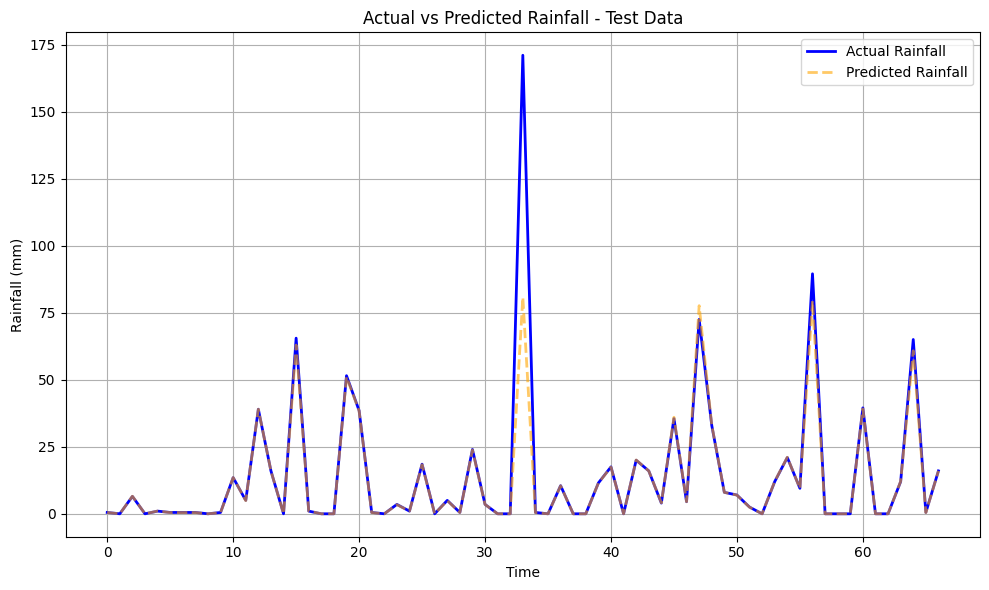

In [20]:
# Predict on the test set
y_pred_scaled = rf.predict(features_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()  # Convert predictions back to original scale
y_test_original = target_scaler.inverse_transform(target_scaled).ravel()  # Convert test targets back to original scale

test_result = pd.DataFrame({
    'y_pred': y_pred,
    'y_test_original': y_test_original
})

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual Rainfall', color='blue', linestyle='-', linewidth=2)
plt.plot(y_pred, label='Predicted Rainfall', color='orange', alpha=0.6, linestyle='--', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall - Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.xlim(30,40)
plt.show()

In [21]:
test_result

,y_pred,y_test_original
0,0.489430,0.5
1,0.000000,0.0
2,6.553293,6.5
3,0.000000,0.0
4,1.023952,1.0
...,...,...
62,0.000000,0.0
63,12.082635,12.0
64,60.795981,65.0
65,0.445278,0.5
